In [2]:
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold

In [3]:
train_df=pd.read_csv('data/infor/training_set.csv')
test_df=pd.read_csv('data/infor/testing_set.csv')
submission=pd.read_csv('data/infor/submission_sample.csv')
capacity=pd.read_csv('data/infor/hotels_capacities.csv',sep=';')
train_df=train_df.merge(capacity, left_on='Hotel_id', right_on='Hotel')
test_df=test_df.merge(capacity, left_on='Hotel_id', right_on='Hotel')
train_df.drop(columns=["Hotel","Row_id"],inplace=True)
test_df.drop(columns=["Hotel"],inplace=True)
submission=submission[:-1]

train_df.head()

,Hotel_id,Date_id,Date,LT,BKG_0,Revenue_0,HotelPrice_0,PriceComp1_0,PriceComp2_0,PriceComp3_0,...,PriceComp3_21,PriceComp4_21,BKG_28,Revenue_28,HotelPrice_28,PriceComp1_28,PriceComp2_28,PriceComp3_28,PriceComp4_28,Capacity
0,1,43354,11/09/2018,37,2.796391,310.465881,209.117233,175.433029,254.684128,169.944260,...,185.216522,223.656219,2.712079,305.808167,241.821213,188.598557,259.636017,186.012878,222.797882,23
1,1,43319,07/08/2018,255,1.829377,267.324188,189.501221,179.592834,216.652176,159.491211,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,23
2,1,43493,28/01/2019,298,0.000000,0.000000,165.191788,106.838440,155.952698,155.888397,...,158.099258,246.577759,0.000000,0.000000,173.946167,102.816086,205.642029,161.208801,260.023560,23
3,1,43371,28/09/2018,220,2.745681,498.146576,170.131302,0.000000,259.400360,235.573364,...,237.755630,250.307373,1.933594,348.409576,180.544403,0.000000,220.558350,229.740631,263.437622,23
4,1,43387,14/10/2018,136,0.925308,178.415405,184.628052,186.085831,244.755524,191.403564,...,181.919266,272.818390,0.913420,175.162933,179.204178,180.829193,248.956894,188.421494,260.718842,23


In [4]:
def decale_date(x,decal):
    
    today = datetime.strptime(x, '%d/%m/%Y')
    yesterday=today - timedelta(days=decal)
    return yesterday.strftime('%d/%m/%Y')
train_df["Extraction_Date"]="1/1/1990"
test_df["Extraction_Date"]="1/1/1990"


In [5]:
train_df["Extraction_Date"]="1/1/1990"
test_df["Extraction_Date"]="1/1/1990"

train_df['Extraction_Date'] = train_df.apply(lambda x: decale_date(x['Date'], x['LT']), axis=1)
test_df['Extraction_Date'] = test_df.apply(lambda x: decale_date(x['Date'], x['LT']), axis=1)

train_df.head()

,Hotel_id,Date_id,Date,LT,BKG_0,Revenue_0,HotelPrice_0,PriceComp1_0,PriceComp2_0,PriceComp3_0,...,PriceComp4_21,BKG_28,Revenue_28,HotelPrice_28,PriceComp1_28,PriceComp2_28,PriceComp3_28,PriceComp4_28,Capacity,Extraction_Date
0,1,43354,11/09/2018,37,2.796391,310.465881,209.117233,175.433029,254.684128,169.944260,...,223.656219,2.712079,305.808167,241.821213,188.598557,259.636017,186.012878,222.797882,23,05/08/2018
1,1,43319,07/08/2018,255,1.829377,267.324188,189.501221,179.592834,216.652176,159.491211,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,23,25/11/2017
2,1,43493,28/01/2019,298,0.000000,0.000000,165.191788,106.838440,155.952698,155.888397,...,246.577759,0.000000,0.000000,173.946167,102.816086,205.642029,161.208801,260.023560,23,05/04/2018
3,1,43371,28/09/2018,220,2.745681,498.146576,170.131302,0.000000,259.400360,235.573364,...,250.307373,1.933594,348.409576,180.544403,0.000000,220.558350,229.740631,263.437622,23,20/02/2018
4,1,43387,14/10/2018,136,0.925308,178.415405,184.628052,186.085831,244.755524,191.403564,...,272.818390,0.913420,175.162933,179.204178,180.829193,248.956894,188.421494,260.718842,23,31/05/2018


In [6]:
def  time_features1(x,date_col,extension): 
    x[date_col]=pd.to_datetime(x[date_col],format='%d/%m/%Y')
    x["dayofweek_"+extension]=x[date_col].dt.dayofweek
    x["dayofyear_"+extension]=x[date_col].dt.dayofyear
    x["dayofmonth_"+extension]=x[date_col].dt.day
    x["year_woy_"+extension]=x[date_col].dt.year.astype(str)+x[date_col].dt.weekofyear.astype(str)
    x["is_weekend_"+extension]=x["dayofweek_"+extension].apply( lambda x : 1 if x  in [5,6] else 0 )
    x["year_"+extension]=x[date_col].dt.year
    x["quarter_"+extension]=x[date_col].dt.quarter
    x["month_"+extension]=x[date_col].dt.month
    x["dayofweek_"+extension]=pd.to_numeric(x[date_col])
    x["dayofyear_"+extension]=pd.to_numeric(x[date_col].dt.dayofyear)
    x["dayofmonth_"+extension]=pd.to_numeric(x[date_col].dt.day)
    x["year_woy_"+extension]=pd.to_numeric(x[date_col].dt.year.astype(str)+x[date_col].dt.weekofyear.astype(str))
    x["is_weekend_"+extension]=pd.to_numeric(x["dayofweek_"+extension].apply( lambda x : 1 if x  in [5,6] else 0 ))
    x["year_"+extension]=pd.to_numeric(x[date_col].dt.year)
    x["quarter_"+extension]=pd.to_numeric(x[date_col].dt.quarter)
    x["month_"+extension]=pd.to_numeric(x[date_col].dt.month)    
    return x 


In [7]:
train_df=time_features1(train_df,'Date','rate')
test_df=time_features1(test_df,'Date','rate')
train_df=time_features1(train_df,'Extraction_Date','extention')
test_df=time_features1(test_df,'Extraction_Date','extention')
train_df.head()

,Hotel_id,Date_id,Date,LT,BKG_0,Revenue_0,HotelPrice_0,PriceComp1_0,PriceComp2_0,PriceComp3_0,...,quarter_rate,month_rate,dayofweek_extention,dayofyear_extention,dayofmonth_extention,year_woy_extention,is_weekend_extention,year_extention,quarter_extention,month_extention
0,1,43354,2018-09-11,37,2.796391,310.465881,209.117233,175.433029,254.684128,169.944260,...,3,9,1533427200000000000,217,5,201831,0,2018,3,8
1,1,43319,2018-08-07,255,1.829377,267.324188,189.501221,179.592834,216.652176,159.491211,...,3,8,1511568000000000000,329,25,201747,0,2017,4,11
2,1,43493,2019-01-28,298,0.000000,0.000000,165.191788,106.838440,155.952698,155.888397,...,1,1,1522886400000000000,95,5,201814,0,2018,2,4
3,1,43371,2018-09-28,220,2.745681,498.146576,170.131302,0.000000,259.400360,235.573364,...,3,9,1519084800000000000,51,20,20188,0,2018,1,2
4,1,43387,2018-10-14,136,0.925308,178.415405,184.628052,186.085831,244.755524,191.403564,...,4,10,1527724800000000000,151,31,201822,0,2018,2,5


In [8]:
train_df.drop(columns=["Date","Extraction_Date"],inplace=True)
test_df.drop(columns=["Date","Extraction_Date"],inplace=True)

In [9]:
train_df.head()

,Hotel_id,Date_id,LT,BKG_0,Revenue_0,HotelPrice_0,PriceComp1_0,PriceComp2_0,PriceComp3_0,PriceComp4_0,...,quarter_rate,month_rate,dayofweek_extention,dayofyear_extention,dayofmonth_extention,year_woy_extention,is_weekend_extention,year_extention,quarter_extention,month_extention
0,1,43354,37,2.796391,310.465881,209.117233,175.433029,254.684128,169.944260,200.156006,...,3,9,1533427200000000000,217,5,201831,0,2018,3,8
1,1,43319,255,1.829377,267.324188,189.501221,179.592834,216.652176,159.491211,251.325089,...,3,8,1511568000000000000,329,25,201747,0,2017,4,11
2,1,43493,298,0.000000,0.000000,165.191788,106.838440,155.952698,155.888397,246.869171,...,1,1,1522886400000000000,95,5,201814,0,2018,2,4
3,1,43371,220,2.745681,498.146576,170.131302,0.000000,259.400360,235.573364,252.521591,...,3,9,1519084800000000000,51,20,20188,0,2018,1,2
4,1,43387,136,0.925308,178.415405,184.628052,186.085831,244.755524,191.403564,265.907135,...,4,10,1527724800000000000,151,31,201822,0,2018,2,5


In [139]:
"""fig = plt.figure(figsize=(25,10))
fig.tight_layout(pad=2, w_pad=2, h_pad=2) # Or equivalently,  "plt.tight_layout()"
for hotel_id in range(1,5):
    #print(hotel_id)
    fig.add_subplot(4, 5,1+5*(hotel_id-1) )
    sns.distplot(train_df[train_df.Hotel_id==hotel_id].HotelPrice_0)
    fig.add_subplot(4, 5,2+5*(hotel_id-1))
    sns.distplot(train_df[train_df.Hotel_id==hotel_id].PriceComp1_0)
    fig.add_subplot(4, 5,3+5*(hotel_id-1))
    sns.distplot(train_df[train_df.Hotel_id==hotel_id].PriceComp2_0)
    fig.add_subplot(4, 5,4+5*(hotel_id-1))
    sns.distplot(train_df[train_df.Hotel_id==hotel_id].PriceComp3_0)
    fig.add_subplot(4, 5,5+5*(hotel_id-1))
    sns.distplot(train_df[train_df.Hotel_id==hotel_id].PriceComp4_0)
#sns.distplot(train_df.PriceComp1_0)"""


'fig = plt.figure(figsize=(25,10))\nfig.tight_layout(pad=2, w_pad=2, h_pad=2) # Or equivalently,  "plt.tight_layout()"\nfor hotel_id in range(1,5):\n    #print(hotel_id)\n    fig.add_subplot(4, 5,1+5*(hotel_id-1) )\n    sns.distplot(train_df[train_df.Hotel_id==hotel_id].HotelPrice_0)\n    fig.add_subplot(4, 5,2+5*(hotel_id-1))\n    sns.distplot(train_df[train_df.Hotel_id==hotel_id].PriceComp1_0)\n    fig.add_subplot(4, 5,3+5*(hotel_id-1))\n    sns.distplot(train_df[train_df.Hotel_id==hotel_id].PriceComp2_0)\n    fig.add_subplot(4, 5,4+5*(hotel_id-1))\n    sns.distplot(train_df[train_df.Hotel_id==hotel_id].PriceComp3_0)\n    fig.add_subplot(4, 5,5+5*(hotel_id-1))\n    sns.distplot(train_df[train_df.Hotel_id==hotel_id].PriceComp4_0)\n#sns.distplot(train_df.PriceComp1_0)'

In [10]:
def train_model_xgb(X_train,Y_train,X_val,Y_val,X_test,parmaters,features_name): 
    d_train = xgb.DMatrix(X_train, Y_train,feature_names=features_name)
    d_valid = xgb.DMatrix(X_val, Y_val,feature_names=features_name)
    d_test = xgb.DMatrix(X_test,feature_names=features_name)
    list_track = [(d_train, 'train'), (d_valid, 'valid')]
    model = xgb.train(parmaters, d_train, 3000,  list_track, maximize=False, verbose_eval=50, early_stopping_rounds=50)
    train_pred =model.predict(d_train)              
    valid_pred =model.predict(d_valid)   
    test_pred = model.predict(d_test)
    return train_pred ,valid_pred,test_pred,model

In [18]:
def train_kfold_xgb(X_train,Y_train,X_test,parmaters,features_name,split=5):
    final_train_pred=np.zeros_like(Y_train)
    final_test_pred=np.zeros(len(X_test))
    from sklearn.model_selection import StratifiedKFold
    kf =  StratifiedKFold(n_splits=split)
    i=1
    
    for train_index, val_index in kf.split(X_train, X_train["Hotel_id"]):
        print("fold:"+str(i))
        train_fold_features, val_fold_features = X_train.loc[train_index], X_train.loc[val_index]
        train_fold_target, val_fold_target = Y_train.loc[train_index], Y_train.loc[val_index] 
        train_pred ,valid_pred,test_pred,model=train_model_xgb( 
                                                        X_train=train_fold_features,
                                                        Y_train= train_fold_target,
                                                        X_val= val_fold_features,
                                                        Y_val= val_fold_target,
                                                        X_test= X_test,
                                                        parmaters=parmaters,
                                                        features_name=features_name 
                                                    )
        
        final_train_pred[val_index]=valid_pred
        final_test_pred=final_test_pred+test_pred
        i=i+1
        
    return final_train_pred,final_test_pred,model


In [14]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


In [15]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)
submission = reduce_mem_usage(submission)


Memory usage after optimization is: 41.16 MB
Decreased by 71.5%
Memory usage after optimization is: 17.93 MB
Decreased by 71.0%
Memory usage after optimization is: 0.73 MB
Decreased by 68.7%


In [130]:
train_df[train_df.LT>330].HotelPrice_0.unique()

array([0.])

In [16]:
tmp_params = {
        # Parameters that we are going to tune.
        'booster': 'gbtree',
        'max_depth':10,
        'min_child_weight': 1,
        'eta':.3,
        'subsample': 1,
        'colsample_bytree': 1,
        # Other parameters
        'objective':'reg:linear'
    }
tmp_params['eval_metric'] = 'rmse'


In [19]:
final_train_pred,final_test_pred,model=train_kfold_xgb(X_train=train_df.drop(columns=['HotelPrice_0']),Y_train=train_df['HotelPrice_0'],X_test=test_df.drop(columns=["Row_id"]),parmaters=tmp_params,features_name=train_df.drop(columns=['HotelPrice_0']).columns,split=5)

fold:1


/home/ec2-user/anaconda3/envs/adanet-env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:87.5666	valid-rmse:87.4267
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:5.67793	valid-rmse:9.39271
[100]	train-rmse:4.17821	valid-rmse:9.03219
[150]	train-rmse:3.3922	valid-rmse:8.90603
[200]	train-rmse:2.79252	valid-rmse:8.83231
[250]	train-rmse:2.35864	valid-rmse:8.78202
[300]	train-rmse:2.01749	valid-rmse:8.74189
[350]	train-rmse:1.74023	valid-rmse:8.70838
[400]	train-rmse:1.53604	valid-rmse:8.69196
[450]	train-rmse:1.34034	valid-rmse:8.67385
[500]	train-rmse:1.18871	valid-rmse:8.65725
[550]	train-rmse:1.04506	valid-rmse:8.64208
[600]	train-rmse:0.914581	valid-rmse:8.62907
[650]	train-rmse:0.817992	valid-rmse:8.62399
[700]	train-rmse:0.740203	valid-rmse:8.61867
[750]	train-rmse:0.66976	valid-rmse:8.61363
[800]	train-rmse:0.595342	valid-rmse:8.60758
[850]	train-rmse:0.541447	valid-rmse:8.60369
[900]	train-rmse:0.48584	valid-rmse:8.60037
[950]	train-rmse:0

In [20]:
train_df.shape

(356720, 52)

In [ ]:
import joblib
#save model
joblib.dump(xgb, 'xgb_basic.model') 

#load saved model
xgb = joblib.load('xgb_basic.model')


In [195]:
model.save_model( 'xgb_basic.model')


In [21]:
from IPython.display import FileLink
def create_submission(submission_file, submission_name):
    submission_file.to_csv(submission_name+".csv",index=False)
    return FileLink(submission_name+".csv")


In [261]:
pd.DataFrame.from_dict({'train':final_train_pred}).to_csv('best_train.csv',index=False)

In [28]:
submission['HotelPrice_0']=final_test_pred
submission.head()

,Row_id,HotelPrice_0
0,1000001,185.331604
1,1000002,161.966660
2,1000003,253.581161
3,1000004,176.160141
4,1000005,134.193665


In [24]:
tmp_test=test_df.copy()
tmp_test['HotelPrice_0']=final_test_pred
tmp_test.loc[tmp_test.LT>340,'HotelPrice_0']=0
tmp_test.head()

,Row_id,Hotel_id,Date_id,LT,BKG_0,Revenue_0,PriceComp1_0,PriceComp2_0,PriceComp3_0,PriceComp4_0,...,month_rate,dayofweek_extention,dayofyear_extention,dayofmonth_extention,year_woy_extention,is_weekend_extention,year_extention,quarter_extention,month_extention,HotelPrice_0
0,1000001,1,43432,309,0,0.0,169.125,179.0,199.0,154.0,...,11,1516665600000000000,23,23,20184,0,2018,1,1,185.331604
1,1000002,1,43269,159,2,390.0,0.000,0.0,189.0,204.0,...,6,1515542400000000000,10,10,20182,0,2018,1,1,161.966660
2,1000003,1,43301,57,9,1777.0,239.000,269.0,209.0,259.0,...,7,1527120000000000000,144,24,201821,0,2018,2,5,253.581161
3,1000004,1,43445,265,0,0.0,99.000,159.0,179.0,154.0,...,12,1521590400000000000,80,21,201812,0,2018,1,3,176.160141
4,1000005,1,43229,105,13,1520.0,126.625,219.0,209.0,209.0,...,5,1516752000000000000,24,24,20184,0,2018,1,1,134.193665


In [25]:
submission['HotelPrice_0']=tmp_test['HotelPrice_0']
submission.head()

,Row_id,HotelPrice_0
0,1000001,185.331604
1,1000002,161.966660
2,1000003,253.581161
3,1000004,176.160141
4,1000005,134.193665


In [29]:
submission['HotelPrice_0']=submission['HotelPrice_0'].apply(lambda x : 0 if x<0 else x )

In [30]:
create_submission(submission, "No_LT_Basic_4Fold_xgboost_fixed")


/home/ec2-user/hamza/kaggle/No_LT_Basic_4Fold_xgboost_fixed.csv

In [ ]:
tr

In [257]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 15

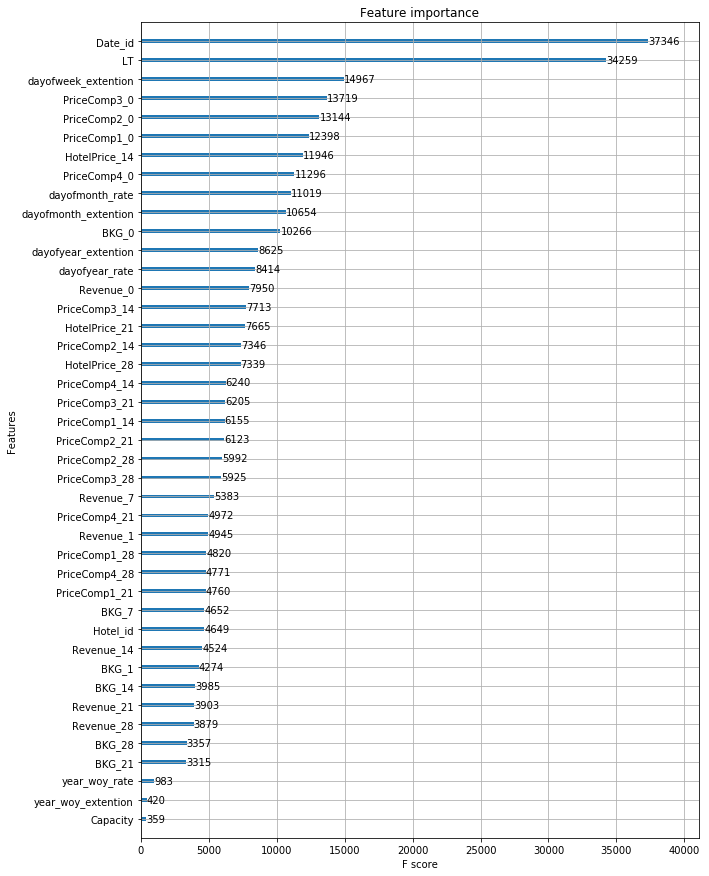

In [258]:
from xgboost import plot_importance
plot_importance(model, )
